In [1]:
import sys
sys.path.append('..')

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import GradCAM, GradCAMpp, XGradCAM, LayerCAM, SmoothGradCAMpp, CAM, SSCAM, ISCAM, ScoreCAM
import torch

model = resnet18(pretrained=False).eval().cuda()
# Get your input
img = read_image("./ILSVRC2012_val_00000293.JPEG")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).cuda()


results_dict = {}
ckpt_list = [
    'demo_model.ckpt', # Path to the checkpoint file
]

method_list = [GradCAM, GradCAMpp, XGradCAM, LayerCAM, SmoothGradCAMpp, CAM, SSCAM, ISCAM, ScoreCAM]

for Method in method_list:
    results_dict[Method.__name__] = []
    for ckpt in ckpt_list:
        ckpt = torch.load(ckpt)['state_dict']
        state_dict = {k.replace('model.', ''): v for k, v in ckpt.items()}

        model.load_state_dict(state_dict)
        with Method(model, target_layer='layer4') as cam_extractor:
            # Preprocess your data and feed it to the model
            out = model(input_tensor.unsqueeze(0))
            # Retrieve the CAM by passing the class index and the model output
            activation_map = cam_extractor(0, out)
            # activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
            results_dict[Method.__name__].append(activation_map)


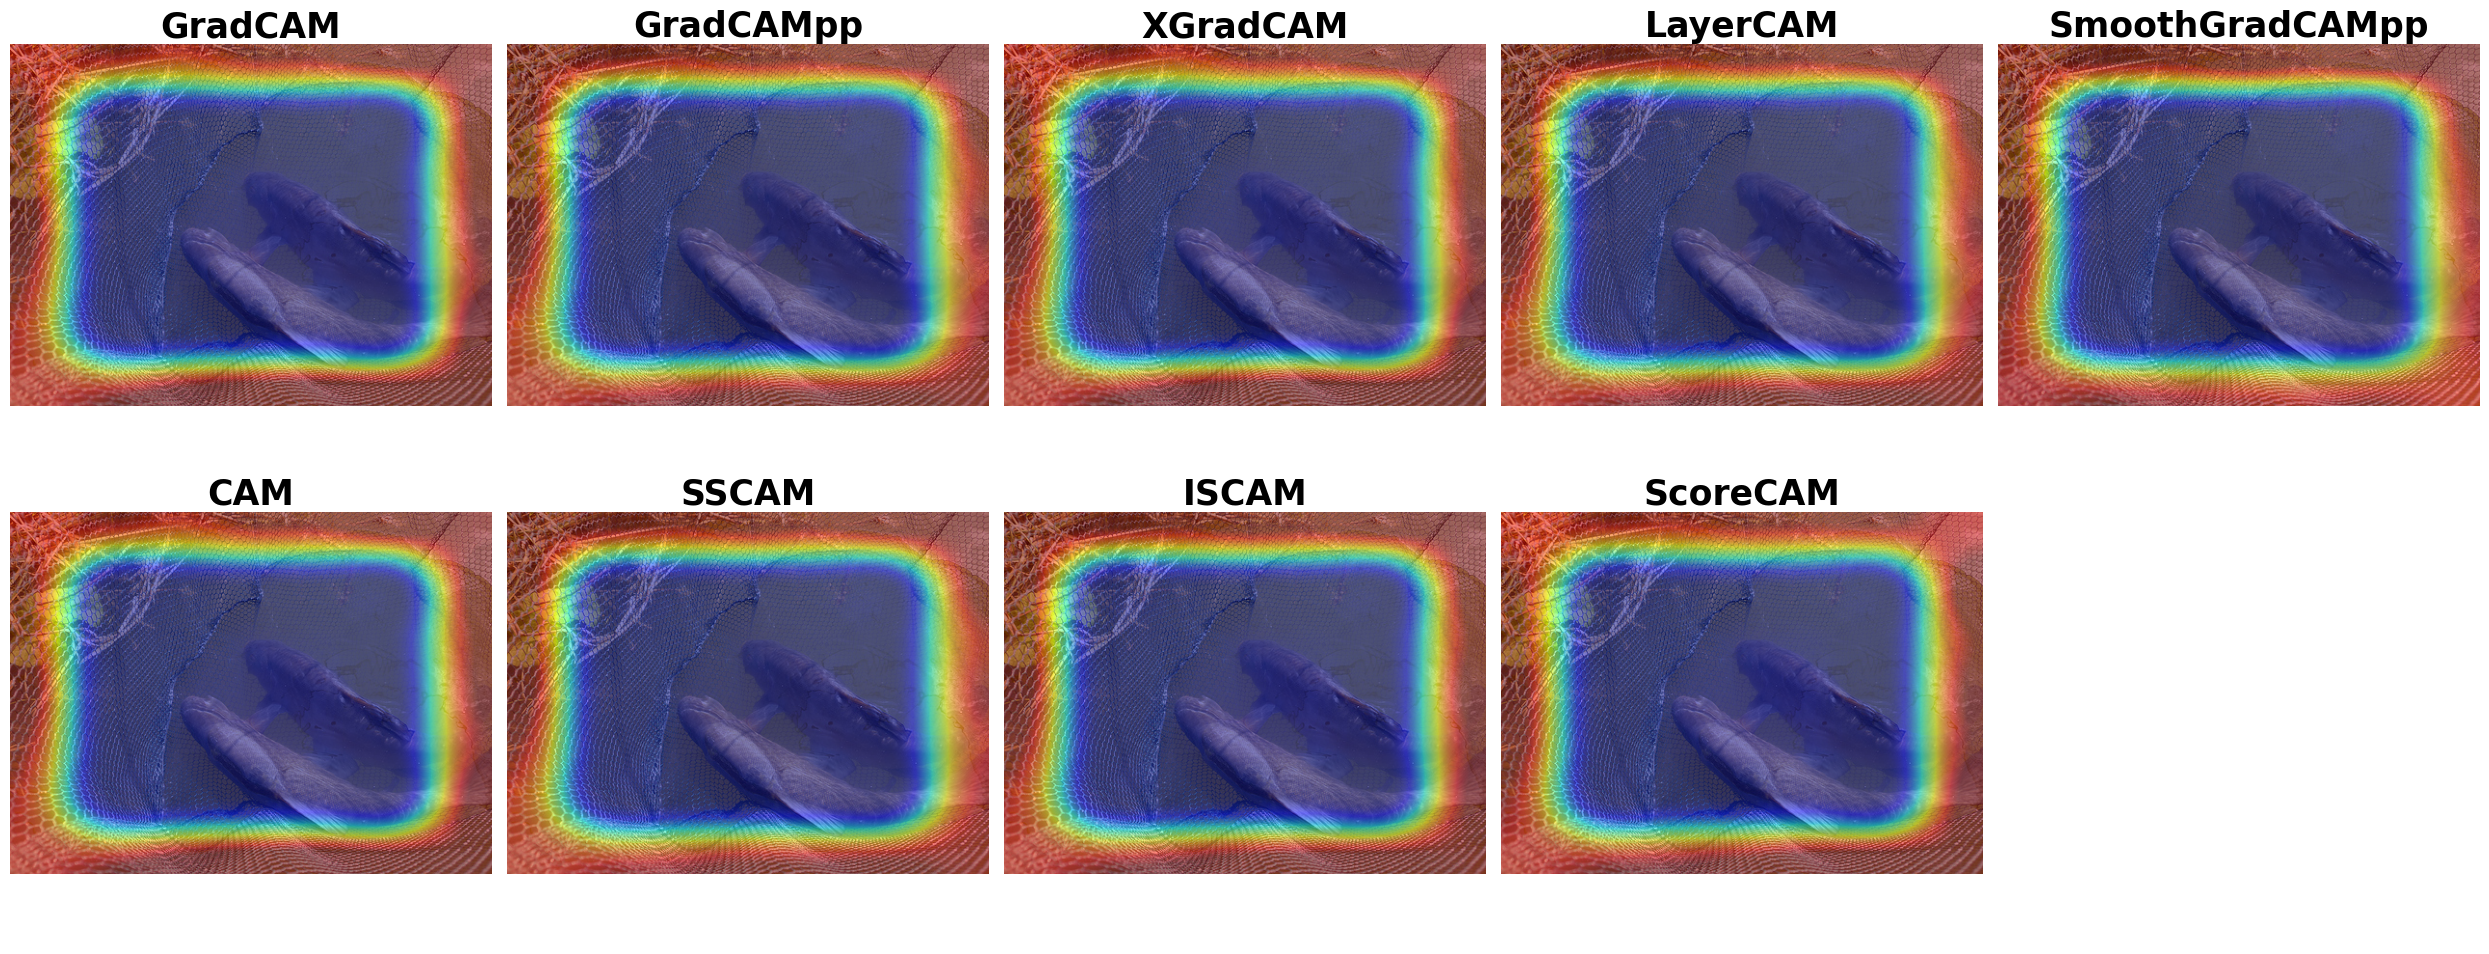

In [3]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

method_names = list(results_dict.keys())
num_row = 2
num_col = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_row, num_col, figsize=(5 * num_col, 5 * num_row))

for i in range(num_row):
    for j in range(num_col):
        ax = axes[i][j]
        
        ax.axis('off')
        idx = num_col*i + j
        if idx == 9:
            break
        method_name = method_names[idx]
        # Retrieve the activation map for the current checkpoint and method
        activation_map = results_dict[method_name][0]
        
        # Resize the CAM and overlay it on the original image
        result = overlay_mask(
            to_pil_image(img),
            to_pil_image(activation_map[0].squeeze(0), mode='F'),
            alpha=0.5
        )
        
        # Display the result
        ax.imshow(result)
        
        # Add titles
        ax.set_title(method_name, fontsize=25, weight='bold')
        if j == 0:
            ax.set_ylabel(f"Ckpt {i + 1}", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()